# 데이터 불러오기

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 학습용/평가용 데이터 분리:train, test
from sklearn.model_selection import train_test_split
# 선형회귀모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환->표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv(r'/home/piai/다운로드/Car_raw_final.csv')

# **전처리**

## **단위 처리**

In [3]:
#단위 제거: Price, Mileage, Engine, Power
df_raw['Price'] = df_raw['Price'] * 1000
df_raw['Mileage'] = df_raw['Mileage'].str.split().str[0].astype(float)
df_raw['Engine'] = df_raw['Engine'].str.split().str[0].astype(float)
df_raw['Power'] = df_raw['Power'].str.split().str[0].astype(float)

## **띄어쓰기, 특수문자 제거**

In [4]:
# 띄어쓰기, 특수문자 제거
df_raw['brand'] = df_raw['Name'].str.split().str[0] #띄어쓰기를 기준으로 각 차량의 model을 파생변수로 생성
df_raw['brand'] = df_raw['brand'].replace('Mercedes-Benz', 'Mercedes_Benz')
df_raw['Owner_Type'] = df_raw['Owner_Type'].replace('Fourth & Above', 'Fourth_Above')

# 결측치 처리 : Mileage(2), Engine(46), Power(46+129), Seats(53+1)에 있던 결측치는 구글링을 통해 채웠음
df_raw['Price'] = df_raw['Price'].fillna(df_raw.groupby(['brand', 'Seats'])['Price'].transform('median')) # 결측값 prcie를 brand와 seats과 같은 데이터들의 중앙값으로 처리하였다.
# brand와 seats과 같은 데이터들이 없는 4개의 데이터들은 제거하였다.
df_raw[df_raw['Price'].isnull()]
df_raw = df_raw.drop(index=[745, 2368, 4843, 4917])

# Seats = 2개인 항목은 총 18개가 있고, 대부분 고급 브랜드의 스포츠카이므로 영향을 많이 주기때문에 따로 관리한다. 따라서 제거하였다.
df_raw = df_raw.drop(df_raw[df_raw['Seats'] == 2.0].index)

# Fuel_Type = Electric인 2개 항목은 데이터가 너무 부족하기때문에 삭제하였다.
df_raw = df_raw.drop(df_raw[df_raw['Fuel_Type'] == 'Electric' ].index)

#new_price는 결측값이 너무 많기때문에 제거하였다.
df_raw.drop('New_Price', axis=1, inplace=True)

## **이상치 처리**

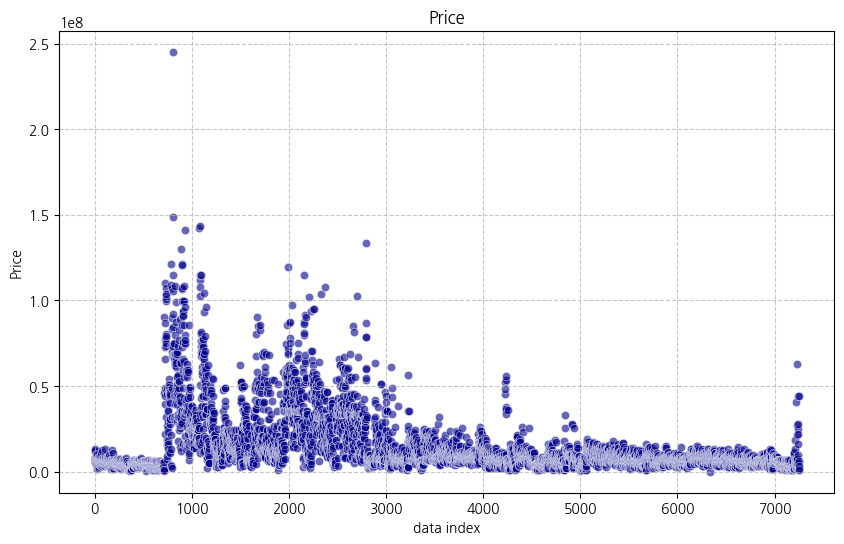

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_raw.index, y=df_raw['Price'], alpha=0.6, color='darkblue')

plt.title('Price')
plt.xlabel('data index')
plt.ylabel('Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Price가 가장 큰 자동차의 모델을 검색했을 때, 신차 가격보다 비싼것을 확인했다. 이상치로 판단하고 삭제하였다.
df_raw[df_raw['Price'] == 2.452736e+08]
df_raw = df_raw.drop(index=810)
# price가 가장 작은 자동차는 7만원으로 비이상적인 값으로 판단하고 삭제하였다.
df_raw[df_raw['Price'] == 7.080000e+03]
df_raw = df_raw.drop(index=6335)
# Kilometers_Driven: Max값을 제거하였다. 
df_raw[df_raw['Kilometers_Driven'] == 6.500000e+06]
df_raw = df_raw.drop(index=897)

## **파생변수**

In [6]:
# 파생변수 0 : brand | name에서 추출한 각 차량의 brand
# 전처리에서 먼저 처리함.

# 파생변수 1 : vehicle_age | 차량 나이
df_raw['vehicle_age'] = 2020 - df_raw['Year']

#파생변수 2 : km_per_year | 연간 주행 거리
df_raw['km_per_year'] = df_raw['Kilometers_Driven'] / df_raw['vehicle_age']

# 파생변수 3: Mileage_per_Engine | 배기량 대비 연비
df_raw['Mileage_per_Engine'] = df_raw['Mileage'] / df_raw['Engine']

# 파생변수 5: power_engine | 배기량 대비 성능
df_raw['power_engine'] = df_raw['Power'] / df_raw['Engine']

# 파생변수 6: warranty | 제조사, 중고차 보증 기간

df_raw['manufacturer_warranty'] = np.where(df_raw['vehicle_age'] < 2, 1, 0) # 제조사 보증기간: 2년 미만인 경우 = 1
df_raw['used_car_warranty'] = np.where(df_raw['vehicle_age'] < 7, 1, 0) # 중고차 보증기간: 7년 미만인 경우 = 1

# 파생변수 7: Region_Hub | 동서남북 지역별 특징
city_to_region = {
    'Delhi': 'Northern_Hub',
    'Jaipur': 'Northern_Hub',
    
    'Mumbai': 'Western_Hub',
    'Pune': 'Western_Hub',
    'Ahmedabad': 'Western_Hub',
    
    'Bangalore': 'Southern_Hub',
    'Hyderabad': 'Southern_Hub',
    'Chennai': 'Southern_Hub',
    'Kochi': 'Southern_Hub',
    'Coimbatore': 'Southern_Hub',
    
    'Kolkata': 'Eastern_Hub'
}

# map() 함수: city_to_region 딕셔너리 기준으로 매핑
df_raw['Region_Hub'] = df_raw['Location'].map(city_to_region)


# 파생변수 8: brand 범주화
PREMIUM = ["Mercedes-Benz", "BMW", "Audi", "Land", "Jaguar", "Porsche", "Volvo", "Mini", "Jeep", "Bentley"]
GENERAL = ["Hyundai", "Honda", "Toyota", "Volkswagen", "Ford", "Mahindra", "Skoda", "Renault", "Nissan", "Mitsubishi", "ISUZU"]
BUDGET = ["Maruti", "Tata", "Chevrolet", "Datsun", "Fiat", "Force", "Ambassador"]

def map_brand_value(brand):
    """브랜드 이름을 받아 브랜드 가치 그룹으로 분류하는 함수"""
    if brand in PREMIUM:
        return 'Premium'
    elif brand in GENERAL:
        return 'General'
    elif brand in BUDGET:
        return 'Budget'
    else:
        return 'Unknown'

df_raw['Brand_Value'] = df_raw['brand'].apply(map_brand_value)


# **전처리 후, 데이터 확인**

전처리 완료 후, 7227개 항목

In [7]:
df_raw.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,...,Seats,brand,vehicle_age,km_per_year,Mileage_per_Engine,power_engine,manufacturer_warranty,used_car_warranty,Region_Hub,Brand_Value
0,Volkswagen Polo 1.0 MPI Trendline,Hyderabad,8707210.0,2019,1000,Petrol,Manual,First,18.78,999.0,...,5,Volkswagen,1,1000.0,0.018799,0.075075,1,1,Southern_Hub,General
1,Renault KWID Climber 1.0 MT,Hyderabad,7358210.0,2018,4126,Petrol,Manual,First,21.70,999.0,...,5,Renault,2,2063.0,0.021722,0.067067,0,1,Southern_Hub,General
2,Renault KWID AMT RXL,Ahmedabad,4982120.0,2017,12000,Petrol,Automatic,Second,24.04,999.0,...,5,Renault,3,4000.0,0.024064,0.067067,0,1,Western_Hub,General
3,Renault KWID Climber 1.0 AMT,Chennai,6898320.0,2018,14000,Petrol,Automatic,First,22.50,999.0,...,5,Renault,2,7000.0,0.022523,0.067067,0,1,Southern_Hub,General
4,Renault KWID Climber 1.0 MT,Delhi,6515080.0,2017,15000,Petrol,Manual,First,21.70,999.0,...,5,Renault,3,5000.0,0.021722,0.067067,0,1,Northern_Hub,General


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7227 entries, 0 to 7252
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7227 non-null   object 
 1   Location               7227 non-null   object 
 2   Price                  7227 non-null   float64
 3   Year                   7227 non-null   int64  
 4   Kilometers_Driven      7227 non-null   int64  
 5   Fuel_Type              7227 non-null   object 
 6   Transmission           7227 non-null   object 
 7   Owner_Type             7227 non-null   object 
 8   Mileage                7227 non-null   float64
 9   Engine                 7227 non-null   float64
 10  Power                  7227 non-null   float64
 11  Seats                  7227 non-null   int64  
 12  brand                  7227 non-null   object 
 13  vehicle_age            7227 non-null   int64  
 14  km_per_year            7227 non-null   float64
 15  Mile

In [9]:
# 통계량 확인

df_raw.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,vehicle_age,km_per_year,Mileage_per_Engine,power_engine,manufacturer_warranty,used_car_warranty
count,7.227000e+03,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000,7227.000000
mean,1.436420e+07,2013.365850,57927.180019,18.332429,1611.592500,111.644495,5.287533,6.634150,9611.803230,0.013259,0.068399,0.016328,0.541580
std,1.623041e+07,3.247105,37488.485981,4.155659,586.432331,52.176756,0.793736,3.247105,6361.391128,0.006206,0.013132,0.126741,0.498303
min,6.745000e+05,1998.000000,171.000000,7.500000,624.000000,34.200000,4.000000,1.000000,97.000000,0.001430,0.023842,0.000000,0.000000
25%,5.748600e+06,2011.000000,34000.000000,15.290000,1198.000000,74.000000,5.000000,4.000000,5862.479167,0.008333,0.060323,0.000000,0.000000
50%,8.277980e+06,2014.000000,53615.000000,18.200000,1493.000000,91.720000,5.000000,6.000000,8340.000000,0.013511,0.067174,0.000000,1.000000
75%,1.494636e+07,2016.000000,73001.500000,21.100000,1968.000000,138.030000,5.000000,9.000000,11792.928571,0.016931,0.074519,0.000000,1.000000
max,1.488044e+08,2019.000000,775000.000000,33.540000,5998.000000,616.000000,10.000000,22.000000,110714.285714,0.042010,0.180814,1.000000,1.000000


In [10]:
# 결측치 확인

df_raw.isnull().sum()

Name                     0
Location                 0
Price                    0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Mileage                  0
Engine                   0
Power                    0
Seats                    0
brand                    0
vehicle_age              0
km_per_year              0
Mileage_per_Engine       0
power_engine             0
manufacturer_warranty    0
used_car_warranty        0
Region_Hub               0
Brand_Value              0
dtype: int64

# **탐색적 분석**

## 시각적 분석

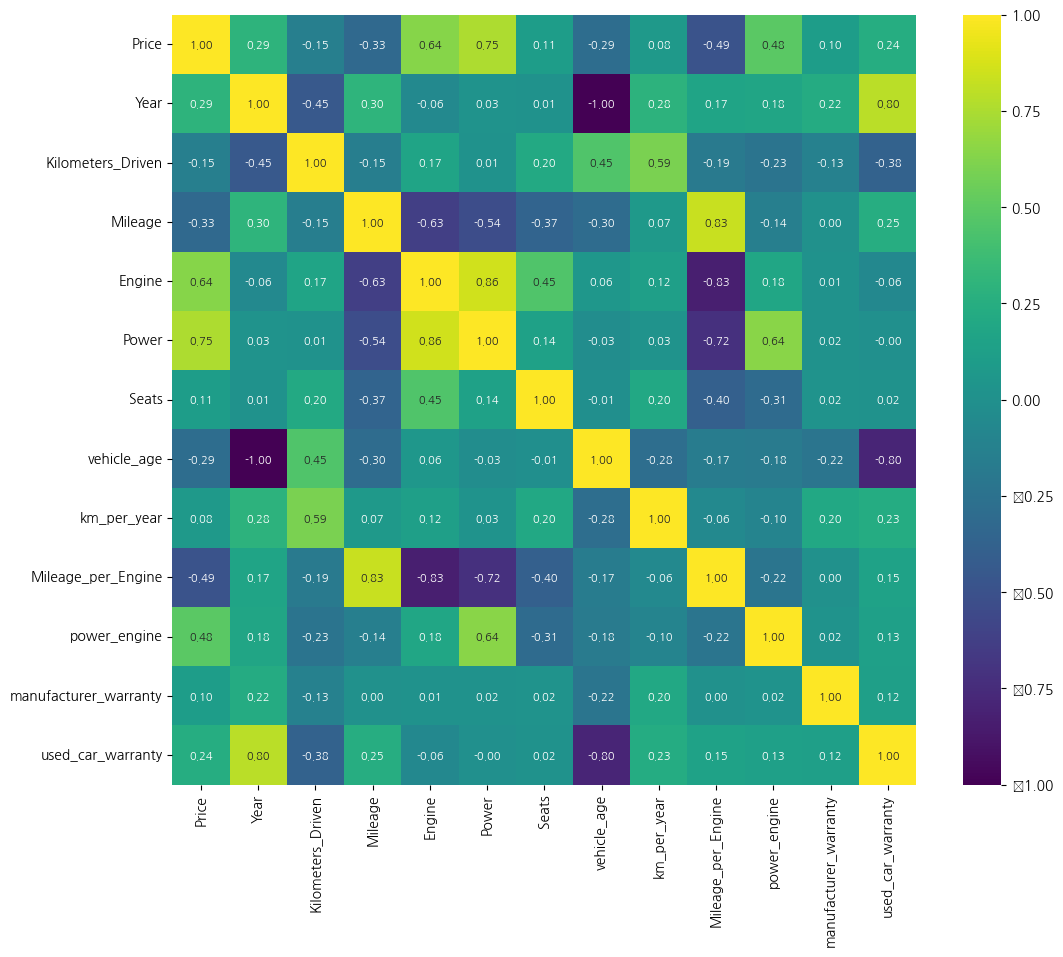

In [11]:
# 히트맵으로 상관관계 확인 

df_numeric = df_raw.select_dtypes(include=[np.number])
df_corr = df_numeric.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(df_corr, annot=True, cmap='viridis', fmt='.2f', annot_kws={'size': 8})

plt.show()

# power, engine, power_engine, mileage 순으로 상관성이 있는 것으로 확인됨

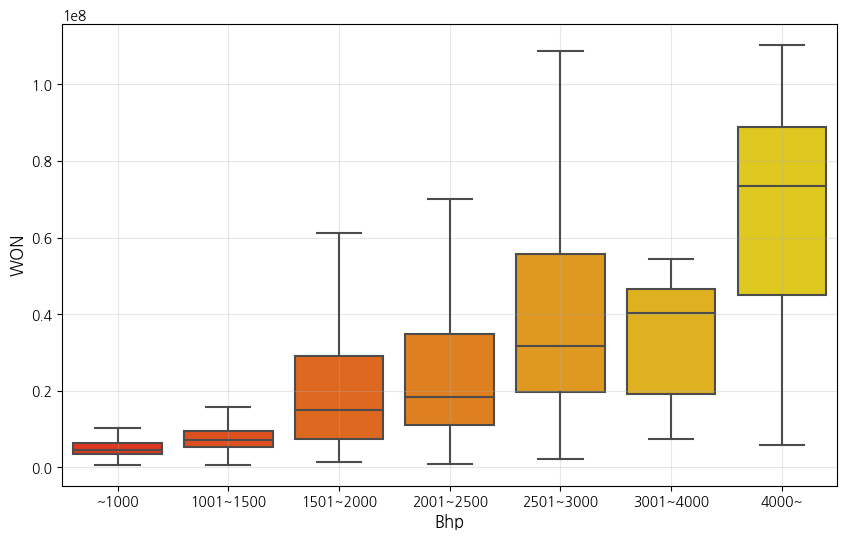

In [12]:
# Engine과 Price의 관계를 Boxplot으로 시각화하였음

plt.figure(figsize=(10,6))

sns.boxplot(
    x=pd.cut(df_raw['Engine'], 
             bins=[0, 1000, 1500, 2000, 2500, 3000, 4000, 6000],
             labels=['~1000', '1001~1500', '1501~2000', '2001~2500', 
                     '2501~3000', '3001~4000', '4000~']),
    y=df_raw['Price'],
    data=df_raw,
    palette='autumn',
    showfliers=False
)

plt.xlabel( 'Bhp', fontsize=12)
plt.ylabel("WON", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

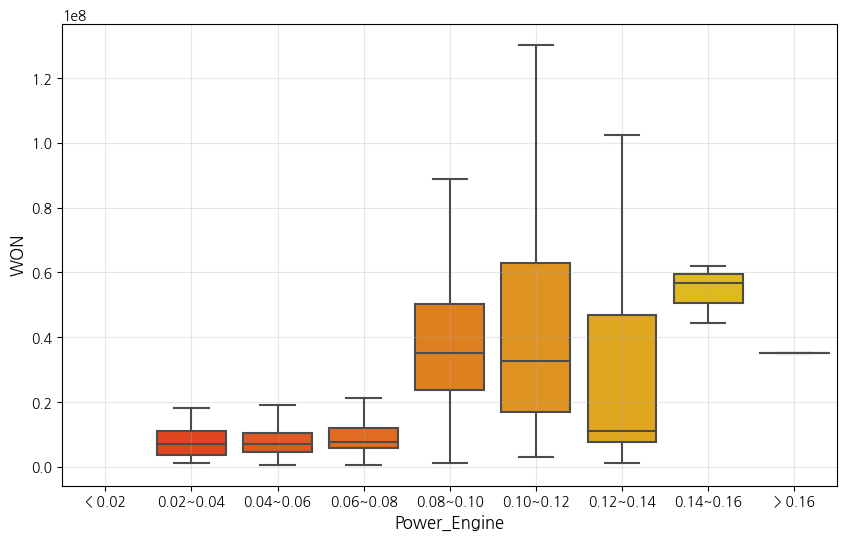

In [13]:
# Engine_Power와 Price의 관계를 Boxplot으로 시각화하였음

plt.figure(figsize=(10,6))
all_bins = [-np.inf, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, np.inf]

all_labels = [
    '< 0.02',    
    '0.02~0.04',  
    '0.04~0.06', 
    '0.06~0.08',  
    '0.08~0.10',  
    '0.10~0.12',  
    '0.12~0.14',  
    '0.14~0.16',  
    '> 0.16'      
]

sns.boxplot(
    x=pd.cut(df_raw['power_engine'], 
             bins=all_bins,   
             labels=all_labels
            ),
    y=df_raw['Price'],
    data=df_raw,
    palette='autumn',
    showfliers=False
)

plt.xlabel("Power_Engine", fontsize=12)
plt.ylabel("WON", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

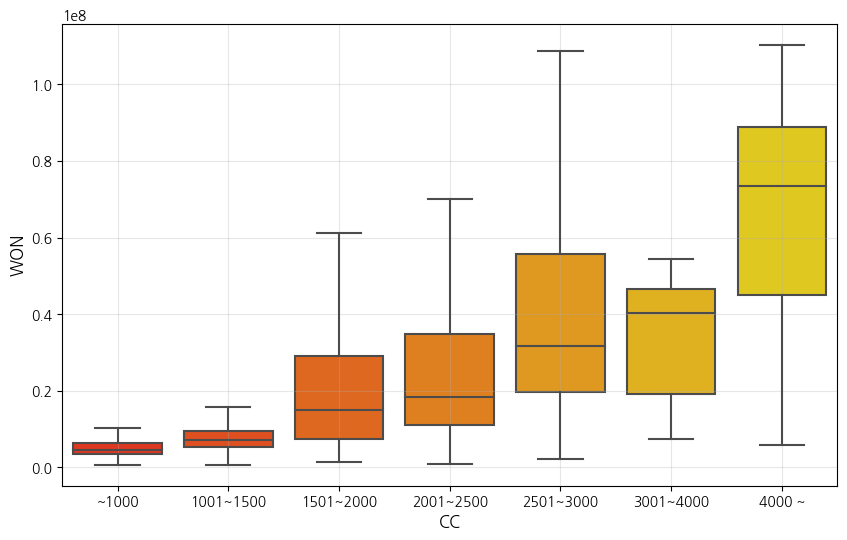

In [14]:
# Engine과 Price의 관계를 Boxplot으로 시각화하였음

plt.figure(figsize=(10,6))

sns.boxplot(
    x=pd.cut(df_raw['Engine'],
             bins=[0, 1000, 1500, 2000, 2500, 3000, 4000, 6000],
             labels=['~1000', '1001~1500', '1501~2000', '2001~2500', '2501~3000', '3001~4000', '4000 ~']),
    y=df_raw['Price'],
    data=df_raw,
    palette='autumn', 
    showfliers=False    
)

plt.xlabel("CC", fontsize=12)
plt.ylabel("WON", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

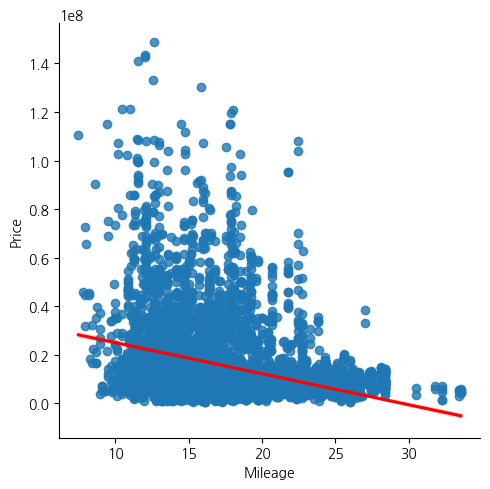

In [15]:
#Mileage와 Price의 관계를 scatter plot으로 시각화하였음

sns.lmplot(x='Mileage', y='Price', data=df_raw, line_kws={'color': 'red'} )

plt.show()

# 예상과는 다르게 연비가 좋다고 가격이 증가하지는 않는다. 다른 설명변수들이 좋은 연비를 상쇄시킬만큼 가격에 영향을 끼치는 것으로 생각된다.

<Axes: xlabel='Brand_Value', ylabel='Power'>

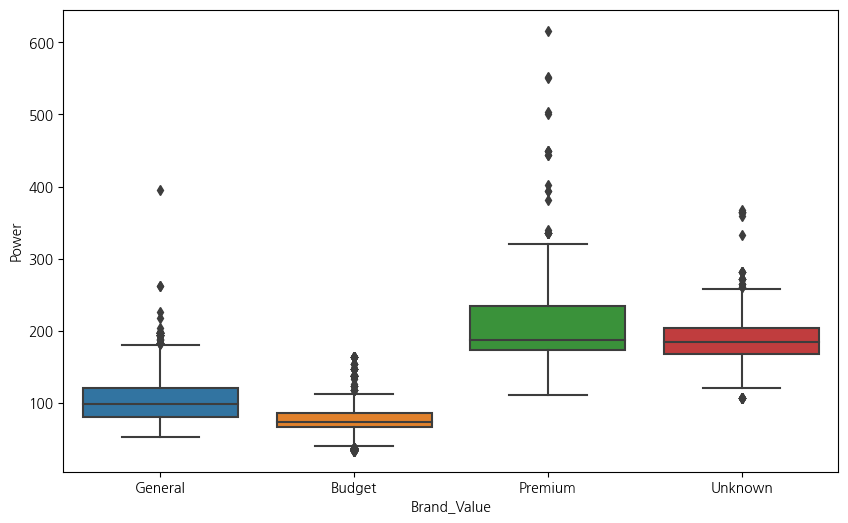

In [16]:
# Brand_Value와 Power의 상관관계를 Box_plot를 통해 확인하였음.
# Premium으로 분류한 모델이 Power가 상대적으로 큰 것을 확인할 수 있다.

plt.figure(figsize=(10,6))
sns.boxplot(x = 'Brand_Value' , y = 'Power', data = df_raw)

# **모델링**

## 다중선형회귀

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7227 entries, 0 to 7252
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7227 non-null   object 
 1   Location               7227 non-null   object 
 2   Price                  7227 non-null   float64
 3   Year                   7227 non-null   int64  
 4   Kilometers_Driven      7227 non-null   int64  
 5   Fuel_Type              7227 non-null   object 
 6   Transmission           7227 non-null   object 
 7   Owner_Type             7227 non-null   object 
 8   Mileage                7227 non-null   float64
 9   Engine                 7227 non-null   float64
 10  Power                  7227 non-null   float64
 11  Seats                  7227 non-null   int64  
 12  brand                  7227 non-null   object 
 13  vehicle_age            7227 non-null   int64  
 14  km_per_year            7227 non-null   float64
 15  Mile

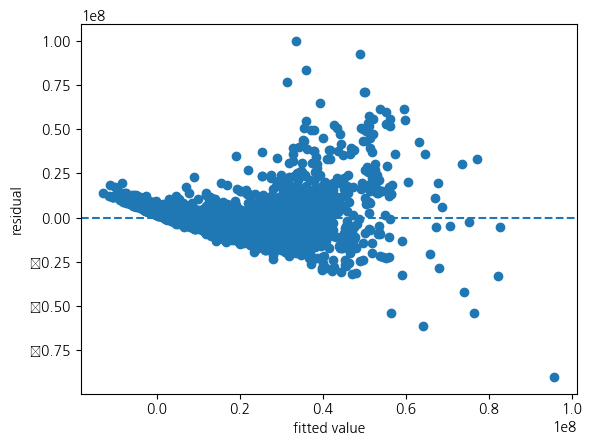

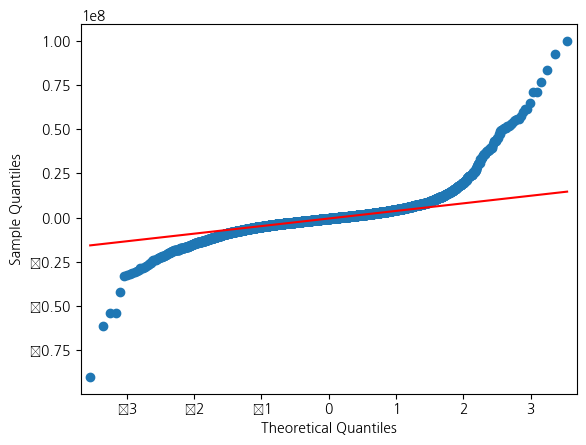

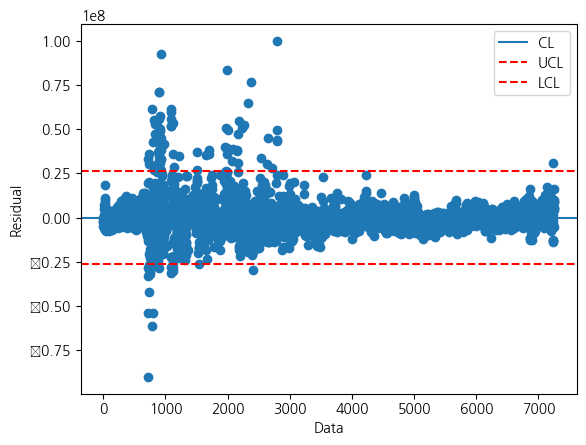

<Axes: >

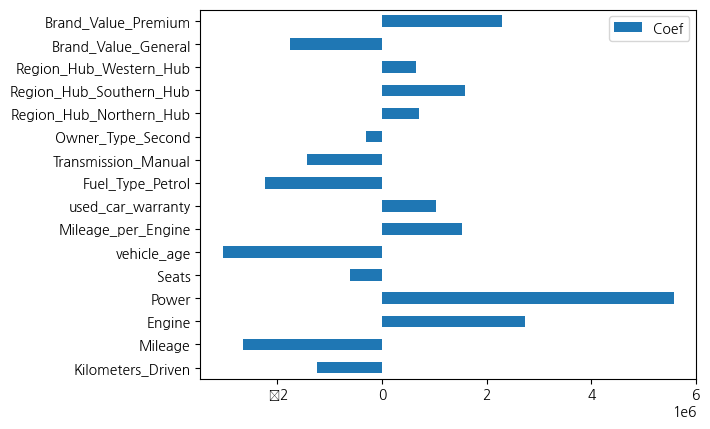

In [17]:
df_model_1 = df_raw.copy()
# 1.
# 일부 컬럼 삭제 및 dummy 처리
df_model_1.info()
df_model_1.drop(['Name', 'Location', 'brand'], axis=1, inplace=True)
# 목표변수/설명변수 분리
df_raw_x_reg = df_model_1.drop("Price", axis = 1, inplace = False)
sr_raw_y_reg = df_model_1["Price"] 
df_raw_y_reg = pd.DataFrame(sr_raw_y_reg, columns=['Price']) 

# 범주형 데이터들을 dummy화
df_raw_dummy_reg = pd.get_dummies(df_raw_x_reg, drop_first = True)
df_raw_dummy_reg.info()

# 2. train / test data 분할
v_feature_names = df_raw_dummy_reg.columns

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
    df_raw_dummy_reg, df_raw_y_reg, 
    test_size=0.3, 
    random_state=1234
)

# 3. Scaling 진행
scaler = StandardScaler()
scaler.fit(x_train_reg)

x_train_scaled_arr = scaler.transform(x_train_reg)
x_test_scaled_arr = scaler.transform(x_test_reg)

x_train_scaled = pd.DataFrame(x_train_scaled_arr, columns=v_feature_names, index=x_train_reg.index)
x_test_scaled = pd.DataFrame(x_test_scaled_arr, columns=v_feature_names, index=x_test_reg.index)

df_train_reg = y_train_reg.join(x_train_scaled) # scaling한 설명형 변수들을 y에 결합
df_test_reg = y_test_reg.join(x_test_scaled)

# 4. 다중선형회귀 모델에 변수들을 넣고 실행. 결과를 계속 확인하면서 후진제거법으로 유의하지않은 변수들부터 제거.
reg_model = smf.ols(formula = "Price ~ Kilometers_Driven + Mileage + Engine + Power\
                            + Seats + vehicle_age + Mileage_per_Engine + used_car_warranty \
                            + Fuel_Type_Petrol + Transmission_Manual + Owner_Type_Second + \
                            Region_Hub_Northern_Hub + Region_Hub_Southern_Hub + Region_Hub_Western_Hub\
                            + Brand_Value_General + Brand_Value_Premium" ,data = df_train_reg)

reg_result = reg_model.fit()
print(reg_result.summary())
# 후진제거법을 통해 독립변수의 p-value가 유의수준인 0.05보다 큰 경우 통계적으로 유의미하지 않아서 제거한다. 
# p-value가 큰 값부터 제거하고 그 독립변수를 제거함으로써 남아있는 변수의 p-value가 바뀌었을 수 있으므로
# 다시 확인 후 그 중에서 큰값을 제거하는 작업을 p-value가 0.05보다 큰 독립변수가 없을 때까지 계속한다.

# 5. 설명변수들간의 다중공선성 확인

df_train_x = df_train_reg[['Kilometers_Driven','Mileage','Engine','Power','Seats','vehicle_age','Mileage_per_Engine','used_car_warranty','Fuel_Type_Petrol','Transmission_Manual','Owner_Type_Second','Region_Hub_Northern_Hub','Region_Hub_Southern_Hub','Region_Hub_Western_Hub','Brand_Value_General','Brand_Value_Premium']]
df_train_x_const = add_constant(df_train_x) # 앞서 만든 statsmodels의 상수항 추가 함수 적용 

df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) \
                 for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF", ascending = True).round(2)


# ======================================EDA 진행================================================
# vehicle_age라는 파생변수는 2020에서 Year을 뺀 값으로 자동차의 연식을 나타내는 변수이다. 
# 결국 vehicle_age라는 파생변수는 Year랑 같은 역할을 수행하는데, 그점을 간과하여 파생변수로 만들었다.
# 다중공선성을 확인해보니 문제가 있는 것을 확인했고 이런식으로 파생변수를 만들면 안된다는 것을 알았다.
# =============================================================================================

# 6. 잔차, 잔차 정규성, 잔차의 독립성을 확인하기위해 시각화 진행
# 잔차 산점도: X-예측값, Y-잔차 
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value"); plt.ylabel("residual")
plt.axhline(y = 0, linestyle = "--")

# 잔차 정규성 검정:Q-Q plot. s-standardized line, 
#  r-regression line, q-quartiles
qqplot(reg_result.resid, line = "q")
plt.show()

# 잔차의 독립성 확인
plt.scatter(df_train_reg.index, reg_result.resid, marker="o")
plt.xlabel("Data") ; plt.ylabel("Residual")
plt.axhline(y=0,linestyle="-", label='CL')
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label='UCL' )
plt.axhline(y=-3*np.std(reg_result.resid),linestyle="dashed",color="red",label='LCL')
plt.legend() ; plt.show()

# 7. 설명변수들의 중요도를 시각화 진행.
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]},  
                           index = ['Kilometers_Driven','Mileage','Engine','Power','Seats','vehicle_age',\
                                    'Mileage_per_Engine','used_car_warranty','Fuel_Type_Petrol','Transmission_Manual',\
                                    'Owner_Type_Second','Region_Hub_Northern_Hub','Region_Hub_Southern_Hub','Region_Hub_Western_Hub'\
                                    ,'Brand_Value_General','Brand_Value_Premium'])
df_reg_coef.plot.barh(y = "Coef")


## Gradient Boosting

Score on training set: 0.906
Score on test set: 0.862
Score on training set: 0.905
Score on test set: 0.863


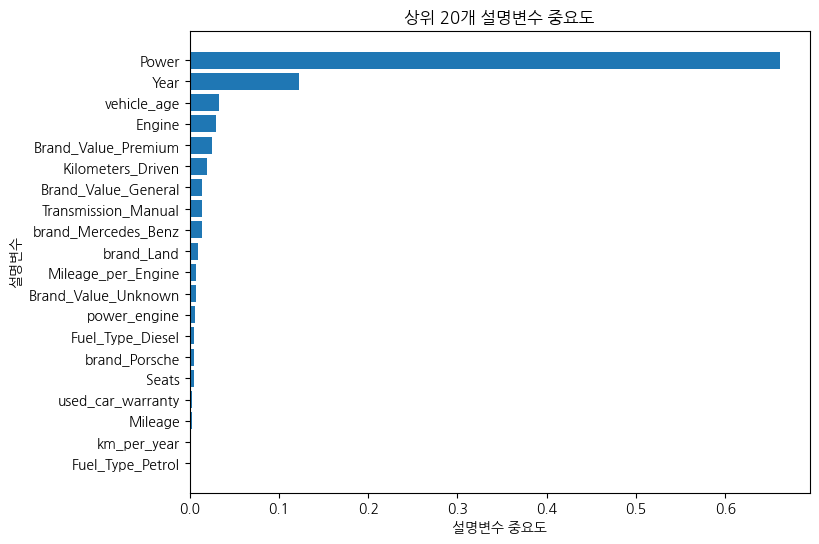

In [31]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. 전처리 한 데이터프레임 불러오기
df_model_2 = df_raw.copy()
# 2. 모델에서 불필요한 설명변수 컬럼 제거
df_model_2.drop(['Name'], axis=1, inplace=True)

# 3. 목표변수, 설명변수 분리 / 범주형 변수 dummy화
df_raw_dummy_GB = pd.get_dummies(df_model_2)

# 목표변수, 설명변수 데이터 지정
df_raw_y_GB = df_raw_dummy_GB["Price"]
df_raw_x_GB = df_raw_dummy_GB.drop("Price", axis = 1, inplace = False)

# 4. train / test 분리
df_train_x_GB, df_test_x_GB, df_train_y_GB, df_test_y_GB = train_test_split(df_raw_x_GB, df_raw_y_GB,\
                                                                test_size = 0.3, random_state = 1234)

5. HyperParameter 조작 전 기본모델 성능확인

gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x_GB, df_train_y_GB)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score (df_train_x_GB, df_train_y_GB)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score (df_test_x_GB, df_test_y_GB)))

# 6. RandomizedSearch를 통한 최적의 hyperparameter 찾기

# param_dist = {
#     "learning_rate": np.linspace(0.05, 0.15, 11), 
#     "n_estimators": [100 ,150, 200, 250, 300],
#     "max_depth": [2, 3, 4],
#     "min_samples_leaf": [6, 8, 10, 12, 14],
#     "min_samples_split": [10, 12, 14, 16, 18, 20, 24],
# }

# rnd = RandomizedSearchCV(
#     GradientBoostingRegressor(random_state=1234),
#     param_distributions=param_dist,
#     n_iter=40, 
#     scoring="r2",
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
#     random_state=1234,
# )
# rnd.fit(df_train_x_GB, df_train_y_GB)
# print(rnd.best_params_, round(rnd.best_score_, 3))

# 최적 parameter를 찾은 후, 주석처리 하였음.
# 최종 결과, n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3,
#          'max_depth': 3, 'learning_rate': 0.1

# 7. 최종모델의 성능확인
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators = 100, min_samples_leaf = 3,
                                     min_samples_split = 10, max_depth = 3, learning_rate = 0.1)
gb_final.fit(df_train_x_GB, df_train_y_GB)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x_GB, df_train_y_GB)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x_GB, df_test_y_GB)))

# 8. 상위 20개의 중요설명 변수들 시각화하여서 확인.

v_feature_name = df_train_x_GB.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
top20 = df_importance.sort_values("Importance", ascending=False).head(20)

# 시각화
plt.figure(figsize=(8,6))
plt.barh(y = range(len(top20)), width = top20["Importance"])
plt.yticks(range(len(top20)), top20["Feature"])
plt.gca().invert_yaxis() 
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")
plt.title("상위 20개 설명변수 중요도")
plt.show()

## Random Forest

Score on training set: 0.980
Score on test set: 0.829
Score on training set: 0.852
Score on test set: 0.831


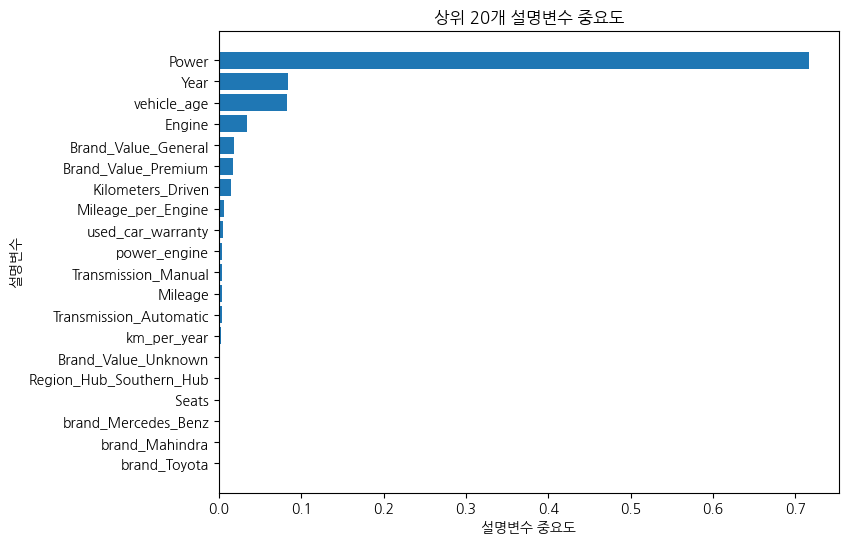

In [ ]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_3 = df_raw.copy()

# 2. 모델에서 불필요한 설명변수 컬럼 제거
df_model_3.drop(['Name'], axis=1, inplace=True)

# 3. 목표변수, 설명변수 분리 / 범주형 변수 dummy화
df_raw_dummy_RF = pd.get_dummies(df_model_3)

# 목표변수, 설명변수 데이터 지정
df_raw_y_RF = df_raw_dummy_RF["Price"]
df_raw_x_RF = df_raw_dummy_RF.drop("Price", axis = 1, inplace = False)

# 4. train / test 분리
df_train_x_RF, df_test_x_RF, df_train_y_RF, df_test_y_RF = train_test_split(df_raw_x_RF, df_raw_y_RF,\
                                                                test_size = 0.3, random_state = 1234)
# 5. HyperParameter 조작 전 기본모델 성능확인

rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x_RF, df_train_y_RF)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score (df_train_x_RF, df_train_y_RF)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score (df_test_x_RF, df_test_y_RF)))


# 6. RandomizedSearch를 통한 최적의 hyperparameter 찾기
# param_dist_rf = {
#     "n_estimators": np.arange(150, 301, 50),
#     "max_depth": np.arange(3, 16),  
#     "min_samples_leaf": np.arange(5, 16), 
#     "min_samples_split": np.arange(16, 41), 
#                 }

# rnd_rf = RandomizedSearchCV(
#     RandomForestRegressor(random_state=1234), 
#     param_distributions=param_dist_rf,       
#     n_iter=40, 
#     scoring="r2",
#     cv=3,
#     n_jobs=-1,
#     random_state=1234,
# )

# rnd_rf.fit(df_train_x_RF, df_train_y_RF) 
# print(rnd_rf.best_params_, round(rnd_rf.best_score_, 3))

# 최적 parameter를 찾은 후, 주석처리 하였음.
# {'n_estimators': 300, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_depth': 11}

# 7. 최종모델의 성능확인
rf_final = RandomForestRegressor(random_state=1234, n_estimators = 300, min_samples_leaf = 19,
                                 min_samples_split = 6, max_depth = 11)
rf_final.fit(df_train_x_RF, df_train_y_RF)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x_RF, df_train_y_RF)))

# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x_RF, df_test_y_RF)))

# 8. 상위 20개의 중요설명 변수들 시각화하여서 확인.

# 변수명
v_feature_names = df_train_x_RF.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)
# 중요도가 높은 순으로 정렬 후 상위 20개 선택
top20 = df_importance.sort_values("Importance", ascending=False).head(20)

# 시각화
plt.figure(figsize=(8,6))
plt.barh(y = range(len(top20)), width = top20["Importance"])
plt.yticks(range(len(top20)), top20["Feature"])
plt.gca().invert_yaxis()  # 중요도 높은 게 위로 오도록 뒤집기
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")
plt.title("상위 20개 설명변수 중요도")
plt.show()

## Decision Tree

In [ ]:
# 1. 전처리 한 데이터프레임 불러오기
df_model_4 = df_raw.copy()

# 2. 모델에서 불필요한 설명변수 컬럼 제거
df_model_4.drop(['Name'], axis=1, inplace=True)

# 3. 목표변수, 설명변수 분리 / 범주형 변수 dummy화
df_raw_dummy_DT = pd.get_dummies(df_model_4)

# 목표변수, 설명변수 데이터 지정
df_raw_y_DT = df_raw_dummy_DT["Price"]
df_raw_x_DT = df_raw_dummy_DT.drop("Price", axis = 1, inplace = False)

# 4. train / test 분리
df_train_x_DT, df_test_x_DT, df_train_y_DT, df_test_y_DT = train_test_split(df_raw_x_DT, df_raw_y_DT,\
                                                                test_size = 0.3, random_state = 1234)
# 5. HyperParameter 조작 전 기본모델 성능확인

tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x_DT, df_train_y_DT)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score (df_train_x_DT, df_train_y_DT)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score (df_test_x_DT, df_test_y_DT)))


# 6. RandomizedSearch를 통한 최적의 hyperparameter 찾기 

# param_dist_dt = {
#     "max_depth": np.arange(10, 21),      
#     "min_samples_leaf": np.arange(5, 16),  
#     "min_samples_split": np.arange(16, 41),  
    
# }

# rnd_dt = RandomizedSearchCV(
#     DecisionTreeRegressor(random_state=1234),
#     param_distributions=param_dist_dt,  
#     n_iter=40, 
#     scoring="r2",
#     cv=3,
#     n_jobs=-1,
#     random_state=1234,
# )


# rnd_dt.fit(df_train_x_DT, df_train_y_DT) 
# print(rnd_dt.best_params_, round(rnd_dt.best_score_, 3))
 
# 7. 최종모델의 성능확인
tree_final = DecisionTreeRegressor(min_samples_leaf = 9, min_samples_split = 37,
                                   max_depth = 19, random_state=1234, )
tree_final.fit(df_train_x_DT, df_train_y_DT)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x_DT, df_train_y_DT)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x_DT, df_test_y_DT)))

# 8. 상위 20개의 중요설명 변수들 시각화하여서 확인.

# 변수명
v_feature_names = df_train_x_DT.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = tree_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)
# 중요도가 높은 순으로 정렬 후 상위 20개 선택
top20 = df_importance.sort_values("Importance", ascending=False).head(20)

# 시각화
plt.figure(figsize=(8,6))
plt.barh(y = range(len(top20)), width = top20["Importance"])
plt.yticks(range(len(top20)), top20["Feature"])
plt.gca().invert_yaxis()  # 중요도 높은 게 위로 오도록 뒤집기
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")
plt.title("상위 20개 설명변수 중요도")
plt.show()

SyntaxError: unexpected character after line continuation character (3258151625.py, line 52)

# **평가**

In [ ]:
# 1. 라이브러리 불러오기
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'NanumSquareRound'

import warnings
warnings.filterwarnings('ignore')

# 2.정제 데이터 불러오기, 필요없는 컬럼 제거
df_est = df_raw.copy()
df_est.drop(['Name'], axis=1, inplace=True)

# 3.  범주형 변수 dummy화 /목표변수, 설명변수 분리 

df_est_dummy = pd.get_dummies(df_est)

# 목표변수, 설명변수 데이터 지정
df_est_y = df_est_dummy["Price"]
df_est_x = df_est_dummy.drop("Price", axis = 1, inplace = False)

# 4. train / test 분리
df_train_est, df_test_est = train_test_split(df_est_dummy, test_size = 0.3, random_state = 1234)
df_train_x_est, df_test_x_est, df_train_y_est, df_test_y_est = train_test_split(df_est_x, df_est_y,\
                                                                test_size = 0.3, random_state = 1234)


# 5. 4개 모델(다중선형회귀, Decision Tree, Random Forest, Gradient Boost) 실행

# 앞선 코드에서 정한 Hyperparameter 값들을 대입하여 모델들을 실행한다.

# 다중선형회귀 모델
reg_model = smf.ols(formula = "Price ~ Kilometers_Driven + Mileage + Engine + Power\
                     + Seats + vehicle_age + Mileage_per_Engine + used_car_warranty \
                     + Fuel_Type_Petrol + Transmission_Manual + Owner_Type_Second + \
                     Region_Hub_Northern_Hub + Region_Hub_Southern_Hub + Region_Hub_Western_Hub\
                     + Brand_Value_General + Brand_Value_Premium" ,
                    data = df_train_est)

reg_result = reg_model.fit()

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=1234, min_samples_leaf = 6, min_samples_split = 30 , max_depth = 6)
dt_model.fit(df_train_x_est, df_train_y_est)

# Random Forest
rf_model = RandomForestRegressor(random_state=1234, n_estimators = 300, min_samples_leaf = 1,
                                 min_samples_split = 5, max_depth = 20)
rf_model.fit(df_train_x_est, df_train_y_est)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=1234, n_estimators = 300, min_samples_leaf = 6, 
                                     min_samples_split = 10, max_depth = 3, learning_rate = 0.13)
gb_model.fit(df_train_x_est, df_train_y_est)


# 6. 모델들의 성능을 시각화하기위해 리스트에 성능 append

# 모델 리스트, 그래프를 그리기 생성 목적
models = ["회귀분석", "의사결정나무", "랜덤 포레스트", "그래디언트 부스팅"]
# 평가 리스트 초기화
mse, rmse, mae, mape = [],[],[],[]

# 회귀분석예측
reg_y_pred = reg_result.predict(df_test_est)

mse.append(mean_squared_error(df_test_y_est, reg_y_pred))
rmse.append(mean_squared_error(df_test_y_est, reg_y_pred, squared=False))
mae.append(mean_absolute_error(df_test_y_est, reg_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y_est, reg_y_pred))

# 의사결정나무예측
dt_y_pred = dt_model.predict(df_test_x_est)

mse.append(mean_squared_error(df_test_y_est, dt_y_pred))
rmse.append(mean_squared_error(df_test_y_est, dt_y_pred, squared=False))
mae.append(mean_absolute_error(df_test_y_est, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y_est, dt_y_pred))

# 랜덤포레스트예측
rf_y_pred = rf_model.predict(df_test_x_est)

mse.append(mean_squared_error(df_test_y_est, rf_y_pred))
rmse.append(mean_squared_error(df_test_y_est, rf_y_pred, squared=False))
mae.append(mean_absolute_error(df_test_y_est, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y_est, rf_y_pred))

# 그래디언트부스팀예측
gb_y_pred = gb_model.predict(df_test_x_est)

mse.append(mean_squared_error(df_test_y_est, gb_y_pred))
rmse.append(mean_squared_error(df_test_y_est, gb_y_pred, squared=False))
mae.append(mean_absolute_error(df_test_y_est, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y_est, gb_y_pred))

# 7.모델 성능 bar graph로 시각화

fig, ax = plt.subplots(2,2, figsize = (13,10))
ax[0, 0].bar(models, mse)
ax[0, 0].set_title("MSE").set_fontsize(15)

ax[0, 1].bar(models, rmse)
ax[0, 1].set_title("RMSE").set_fontsize(15)

ax[1, 0].bar(models, mae)
ax[1, 0].set_title("MAE").set_fontsize(15)

ax[1, 1].bar(models, mape)
ax[1, 1].set_title("MAPE").set_fontsize(15)